# Assignment - Recommender Systems via Graph Neural Networks

In this task, we will implement the RippleNet model from the [paper](https://arxiv.org/pdf/1803.03467.pdf). The model utilizes information from the knowledge graph to enforce the recommendation performance.

![test](https://recbole.io/docs/v0.1.2/_images/ripplenet.jpg)

The picture depicts the general pipeline of the model.

The upper part of the image shows the construction of the ripple sets. The seed nodes are the items that users already like. We construct ripple sets as a k-hop neighborhood of the corresponding seed nodes.

The architecture scheme defines the prediction pipeline. We iteratively aggregate the information from k-hop neighbors to receive the user embedding. Finally, we take the scalar product between received user embedding and initial item one to receive the probability.

We will start by preparing the dataset and visualization of the knowledge graph slice. Then we will implement the torch dataset, which is able to find ripple sets. After, we will define the model, train it and try to interpret some predictions.

In [1]:
import numpy as np
import pandas as pd
import collections
import requests

import torch
from torch import nn
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

## Data preparation

We will work with the MovieLens-1m dataset linked to the knowledge base.

We will only use the information about user-movie interactions from the MovieLens. The data in the proposed archive is already preprocessed. Firstly, item indices are aligned between the knowledge graph and the rating matrix. Secondly, ratings are converted to binary format. In this task, we will suppose that if the rating is greater than 3, the user likes the movie, so that we will plot the edge between them. Otherwise, the rating is negative, and the edge will be skipped, but we will propagate the negative value to the loss.

Let us download the datasets.

In [2]:
open('id2relation.json', 'wb').write(requests.get('https://raw.githubusercontent.com/netspractice/advanced_gnn/main/assignment_recsys/data/id2relation.json').content)
open('id2title.json', 'wb').write(requests.get('https://raw.githubusercontent.com/netspractice/advanced_gnn/main/assignment_recsys/data/id2title.json').content)
open('kg_final.npy', 'wb').write(requests.get('https://github.com/netspractice/advanced_gnn/raw/main/assignment_recsys/data/kg_final.npy').content)
open('ratings_final.npy', 'wb').write(requests.get('https://github.com/netspractice/advanced_gnn/raw/main/assignment_recsys/data/ratings_final.npy').content)

9045392

The `ml-kg-preprocessed/ratings_final.npy` contains preprocessed user-item interaction matrix. The `ml-kg-preprocessed/kg_final.npy` contains knowledge graph triplets (head, relation and tail).

In [3]:
ratings = np.load("ratings_final.npy")
kg_edges = np.load("kg_final.npy")

Additionally, we have to mappings: movie id to title and relation id to its name.

In [4]:
import json
import networkx as nx
from matplotlib import pyplot as plt 


with open("id2relation.json") as f:
    id2relation = {int(i):j for i, j in json.load(f).items()}

with open("id2title.json") as f:
    id2title = {int(i):j for i, j in json.load(f).items()}

And for the visualization let us convert kg triplets to the pandas dataframe

In [5]:
kg_edges_pd = pd.DataFrame(kg_edges)
kg_edges_pd.columns = ["head", "relation", "tail"]
kg_edges_pd.relation = kg_edges_pd.relation.map(id2relation)

In [6]:
kg_edges_pd.head()

,head,relation,tail
0,2445,film.actor.film,2446
1,2447,film.person_or_entity_appearing_in_film.film,2448
2,2449,film.film.genre,2450
3,2451,film.actor.film,2452
4,2453,film.actor.film,2454


## Task 1. Knowledge subgraph visualization (1 point)

Let us visualize a part of a graph to understand how it looks like.

Firstly, we need to define the function `find_neighbors_by_tail` that will return all triplets adjacent to tails achievable from the specific `movie_id`. Due to the large degree of specific entities (e.g. English language), we will truncate the number of possible movie_id tails by the least `k_tails`. The `kg_edges` 

The function should work as follows:

1. Select the part of `kg_edges_pd` where `head` is equal to `movie_id`
2. Extract all possible tails
3. Select the part of `kg_edges_pd` where `tail` is in tails array from step 2
4. Calculate the occurrence of tails in the subgraph 3
5. Select only the least `k_tails` from them
6. Filter the subgraph from 3 by the tails list from 5
7. Filter the subgraph whether `head` is in the `id2title` map
8. Create column `tail_type` with the last word after the dot in the `relation`

In [7]:
def find_neighbors_by_tail(movie_id, kg_edges_pd, k_tails=5):
    tails = kg_edges_pd[kg_edges_pd['head'] == movie_id]['tail'].values
    tails_df = kg_edges_pd[kg_edges_pd['tail'].isin(tails)]
    k_least_tails = tails_df.groupby('tail').size().sort_values()[:5].index.values
    filtered = tails_df[tails_df['tail'].isin(k_least_tails)]
    filtered = filtered[filtered['head'].isin(id2title.keys())]
    filtered['tail_type'] = filtered.relation.apply(lambda t: t.split('.')[-1])
    return filtered

In [8]:
neighbors = find_neighbors_by_tail(0, kg_edges_pd)
assert neighbors.columns.tolist() == ["head", "relation", "tail", "tail_type"]
assert neighbors.shape[0] == 13

Next, let us define the `find_positions` method, which takes the result of `find_neighbors_by_tail` and assign the positions on a 2d figure for each entity. Also, it should return the mapping from entity id to its types. The type of the tail is defined by its `tail_type` columns values. The type of elements in the `head` column is a `"title"`.

The `find_positions_and_ntypes` should work as follows:

1. Define mapping from entity id to its type as described in the previous paragraph
2. If the node type is equal to the `title`, then x coordinate equals `1`. Otherwise, it equals `2`
3. The elements inside each group should be placed through equal intervals inside the `(0, 1)` range
4. Method should return two dictionaries. The first with a mapping from entity id to the tuple of (x, y) position, the second with the mapping from entity id to the node types

In [ ]:
neighbors

,head,relation,tail,tail_type
50738,1419,film.film.director,49232,director
62866,1981,film.film.writer,43078,writer
347903,0,film.film.writer,49232,writer
431598,1021,film.film.writer,43078,writer
503719,0,film.film.writer,23760,writer
526696,0,film.film.director,12304,director
697383,0,film.film.writer,6822,writer
707653,1419,film.film.director,12304,director
798378,1889,film.film.writer,49232,writer
908031,2307,film.film.writer,43078,writer


In [ ]:
heads_values = np.unique(neighbors['head'].values)
heads = pd.DataFrame(index=heads_values, columns=['ntype'])
heads['ntype'] = 'title'
heads = heads.to_dict()['ntype']
tails = neighbors.set_index('tail', drop=False)['tail_type'].to_dict()
heads.update(tails)

n = len(heads_values)
pos_heads = {id_: coord for id_, coord in zip(heads_values, list(zip([1] * n, np.linspace(0, 1, n))))}
tails_values = [t for t in tails.keys()]
n = len(tails_values)
pos_tails = {id_: coord for id_, coord in zip(tails_values, list(zip([2] * n, np.linspace(0, 1, n))))}
pos_heads.update(pos_tails)

In [ ]:
pos_heads

{0: (1, 0.0),
 1021: (1, 0.2),
 1419: (1, 0.4),
 1889: (1, 0.6000000000000001),
 1981: (1, 0.8),
 2307: (1, 1.0),
 49232: (2, 0.0),
 43078: (2, 0.25),
 23760: (2, 0.5),
 12304: (2, 0.75),
 6822: (2, 1.0)}

In [9]:
def find_positions_and_ntypes(neighbors):
    heads_values = np.unique(neighbors['head'].values)
    heads = pd.DataFrame(index=heads_values, columns=['ntype'])
    heads['ntype'] = 'title'
    heads = heads.to_dict()['ntype']
    tails = neighbors.set_index('tail', drop=False)['tail_type'].to_dict()
    heads.update(tails)

    n = len(heads_values)
    pos_heads = {id_: coord for id_, coord in zip(heads_values, list(zip([1] * n, np.linspace(0, 1, n))))}
    tails_values = [t for t in tails.keys()]
    n = len(tails_values)
    pos_tails = {id_: coord for id_, coord in zip(tails_values, list(zip([2] * n, np.linspace(0, 1, n))))}
    pos_heads.update(pos_tails)

    return pos_heads, heads

In [10]:
pos, ntype = find_positions_and_ntypes(neighbors)
assert ntype[0] == "title"
assert pos[0][0] == 1

Now, we can visualize the knowledge graph part

In [ ]:
g = nx.from_edgelist(neighbors[["head", "tail"]].values)

In [ ]:
g.nodes()

NodeView((1419, 49232, 1981, 43078, 0, 1021, 23760, 12304, 6822, 1889, 2307))

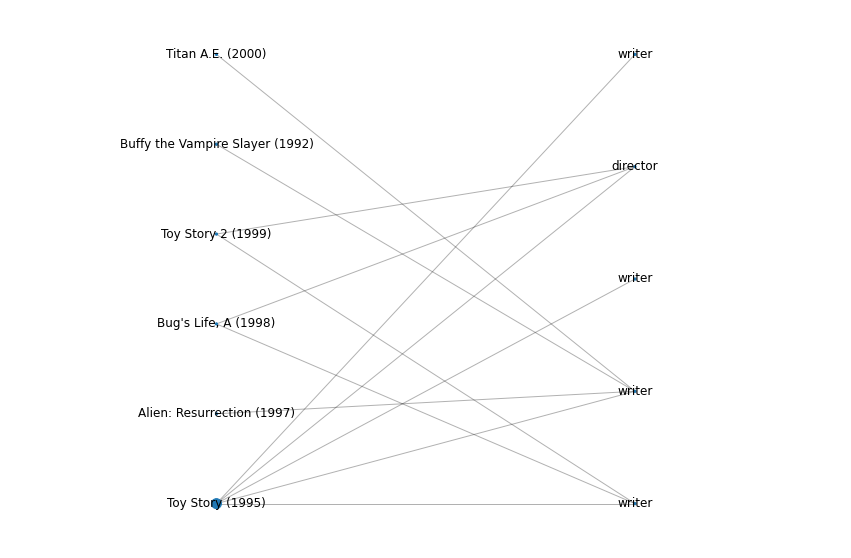

In [11]:
def visualize_kg_part(movie_id, kg_edges, k_tails=5):
    neighbors = find_neighbors_by_tail(movie_id, kg_edges, k_tails)
    pos, ntypes = find_positions_and_ntypes(neighbors)
    
    g = nx.from_edgelist(neighbors[["head", "tail"]].values)
    labels = ntypes.copy()
    labels.update({i: j for i,j in id2title.items() if i in ntypes})
    f, ax = plt.subplots(1, 1, figsize=[15, 10])
    plt.axis("off")
    ax.set_xlim((0.5, 2.5))
    nx.draw_networkx_labels(g, pos=pos, labels=labels)
    nx.draw_networkx_nodes(g, pos=pos,  ax=ax, node_size=[(100 if i == movie_id else 5) for i in g.nodes])
    nx.draw_networkx_edges(g, pos=pos, edgelist=g.edges(), alpha=0.3)

visualize_kg_part(0, kg_edges_pd)

Here, we can see that `Toy Story` has similar director and writers with the second part of the title and with `Bug's Life`. Additionally, it shares writers with the movies `Titan A.E.`, `Alien: Resurrection` and `Buffy the Vampire Slayer`.

We can see similar logic in the picture from the paper.

<img src="https://img2018.cnblogs.com/i-beta/1338991/201911/
1338991-20191128135255625-1310374474.png" width="500" />

The RippleNet model intuition is that knowledge graph defines meaningful connections between movie titles within the two hops of a knowledge graph. So this information can help to find the best choices to recommend.

For example, let us consider the case of collaborative filtering. It defines the similarity between titles through the item co-occurrence within the history of a user. So, for example, in this case `Toy Story` and `Toy Story 2` will be similar only when many users watch both films. However, a knowledge graph provides an opportunity to know its similarity in advance because it shares several neighbours.

Now, we need to split ratings into train, validation and test parts.

In [12]:
np.random.seed(0)

idx = np.random.permutation(ratings.shape[0])

train_idx = idx[:int(0.6 * idx.shape[0])]
val_idx = idx[int(0.6 * idx.shape[0]):int(0.8 * idx.shape[0])]
test_idx = idx[int(0.8 * idx.shape[0]):]

## Task 2. Graphs preparation (1 point)

Let us define the train graph of user-item interactions. It could be represented as a mapping from the user id to the list of all liked (positive) titles by a user.

The rating array has three columns:
1. User id
2. Item id
3. Rating (0 or 1)

The function should work as follows:

1. Iterate over `train_idx`
2. If `rating` is positive, then append item id to corresponding user id key history

In [13]:
def convert_ratings_to_user_history(ratings, train_idx):
    train_rating = ratings[train_idx]
    indices = np.unique(train_rating[:, 0])
    user_history_dict = {}

    for idx in indices:
        liked_items = train_rating[np.logical_and((train_rating[:, 0] == idx), (train_rating[:, 2] == 1))][:, 1]
        user_history_dict[idx] = liked_items
    return user_history_dict

In [14]:
user_history_dict = convert_ratings_to_user_history(ratings, train_idx)
assert 624 in user_history_dict[0]
assert len(user_history_dict[0]) == 13

Let us filter indices if users are not presented in the user history graph

In [15]:
train_idx = [i for i in train_idx if ratings[i][0] in user_history_dict]
val_idx = [i for i in val_idx if ratings[i][0] in user_history_dict]
test_idx = [i for i in test_idx if ratings[i][0] in user_history_dict]

And finally, we can define the train, val and test 
subsets

In [16]:
train_data = ratings[train_idx]
val_data = ratings[val_idx]
test_data = ratings[test_idx]

Now, we need to transform our knowledge graph edges into the dictionary where the key is heads and values is a list of tuples `(tail, relation)`

In [19]:
def transform_kg(kg_edges):
    kgdf = pd.DataFrame(kg_edges, columns=['heads', 'relations', 'tails'])
    kgdf['pairs'] = kgdf.apply(lambda t: (t[2], t[1]), axis=1)
    grouped = kgdf.groupby('heads')
    
    kg = {}

    for name, group in grouped:
        kg[name] = group['pairs'].values.tolist()
    
    return kg

In [20]:
kg = transform_kg(kg_edges)

assert kg[0][0] == (2755, 10)

## Task 3. Ripple sets (3 points)

One of the main concepts in the paper is a RippleSet. RippleSet is an array of all neighboring triplets to our node within the given number of hop.

Some entities have a substantial degree that could cover almost the whole graph. So to reduce the complexity of a model, we will use only a fixed uniform subsample of neighbors on each hop.

Here, the `find_ripple` method should be defined in the following way
1. Iterate over the number of hops
2. Find neighbors to the tails of the previous hop (at the start, it is equal to the user history array)
3. Preserve the triplet defined by it (head, relation, tail) in different arrays. 
4. Convert it to the torch.LongTensor
5. Append it to the user ripple set array.

So ripple set for a user with two- and three-hop neighbors sample will look like

```
[
  [
    torch.LongTensor([0, 1, 2]), # first hop head ids
    torch.LongTensor([0, 1, 2]), # first hop relation ids
    torch.LongTensor([5, 2, 9]), # first hop tail ids
  ],
  [
    torch.LongTensor([5, 2, 2]), # second hop head ids (subsample of previous tails)
    torch.LongTensor([3, 1, 5]), # second hop head ids
    torch.LongTensor([10, 3, 1]), # second hop relation ids
  ]
]
```


In [21]:
def find_ripple(user, user_history_dict, kg, num_hops=2, num_neighbors=32):
    tails = user_history_dict[0]
    possible_heads = set(kg.keys())
    triplets = []

    for _ in range(num_hops):
        triplet = []
        possible_tails = set(tails).intersection(possible_heads)
        heads = np.random.choice(list(possible_tails), num_neighbors)
        tails = [kg[head] for head in heads]
        all_tails = []
        _ = [all_tails.extend(tail) for tail in tails]
        selected = np.random.choice(range(len(all_tails)), num_neighbors)
        rel_tails = np.array(all_tails)[selected]
        tails = [t[0] for t in rel_tails]
        relations = [r[1] for r in rel_tails]
        triplet.append(torch.tensor(heads, dtype=torch.long))
        triplet.append(torch.tensor(relations, dtype=torch.long))
        triplet.append(torch.tensor(tails, dtype=torch.long))
        triplets.append(triplet)
        
    return triplets

In [22]:
ripple = find_ripple(0, user_history_dict, kg)

assert len(ripple) == 2
assert ripple[0][0].shape[0] == 32
assert len(set([i.item() for i in ripple[0][0]]) - set(user_history_dict[0])) == 0
assert len(set([i.item() for i in ripple[1][0]]) - set([i.item() for i in ripple[0][2]])) == 0

In the next cell, we will implement the `__getitem__` method for RippleDataset.

The `idx` is an integer index of an element in the rating matrix.
We need to extract the user, item and label from it and add the ripple set for a given user.

In [23]:
class RippleDataset(Dataset):
    def __init__(self, ratings, ripple_set):
        self.ratings = torch.LongTensor(ratings)
        self.ripple_set = ripple_set
    
    def __len__(self):
        return self.ratings.shape[0]
    
    def __getitem__(self, idx):
        user = self.ratings[idx][0]
        item = self.ratings[idx][1]
        label = self.ratings[idx][2]
        ripple = self.ripple_set[user.item()]
        return user, item, label, ripple

Now, we can define the dataloader for train, validation and test

In [24]:
ripple_set = {user: find_ripple(user, user_history_dict, kg) for user in user_history_dict}

train_dataset = RippleDataset(train_data, ripple_set)
val_dataset = RippleDataset(val_data, ripple_set)
test_dataset = RippleDataset(test_data, ripple_set)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=True)

In [25]:
user, item, label, ripple = train_dataset.__getitem__(0)
assert user.item() == 441
assert item.item() == 658
assert label.item() == 1
assert len(ripple) == 2

## Task 4. Model definition (2 points)

To explain how the model works, let us refer to the picture from the start of the notebook.

![test](https://recbole.io/docs/v0.1.2/_images/ripplenet.jpg)

1. Firstly, we need to encode all the entities: items, heads, relations and tails in the ripple sets
2. Then, we need to construct vectors that represent each hop of neighborhood (`key_addressing` method)
3. We need to calculate the user embedding by taking the sum of all hop vectors.
4. Finally, we can calculate the affinity score between user and item representations by taking the dot product of them and normalizing it with a sigmoid function


The `key_addressing` function works as follows:

1. Iterate over each hop
2. Project the head to the tail space by multiplying it on the relations embedding
3. Multiply the item embeddings by the projected heads from step 2 and normalize it via softmax to calculate the tail weights
4. Calculate the hop representation by taking the weighted average of tail vectors relative to probabilities from step 3.
5. Concatenate the item embeddings with a result of step 4.
6. Project the result of 5 using `transform_matrix`
7. Safe the resulting hop vector
8. After all iterations, sum all weights from 7 to receive the user_embedding

In [26]:
class RippleNet(nn.Module):
    def __init__(self, n_entity, n_relation, dim):
        super(RippleNet, self).__init__()

        self.n_entity = n_entity
        self.n_relation = n_relation
        self.dim = dim

        self.entity_emb = nn.Embedding(self.n_entity, self.dim)
        self.relation_emb = nn.Embedding(self.n_relation, self.dim * self.dim)
        self.transform_matrix = nn.Linear(self.dim * 2, self.dim, bias=False)

    def forward(self, items, ripples):
        item_embeddings = self.entity_emb(items)
        head_embs = []
        rel_embs = []
        tail_embs = []
        
        for heads, rels, tails in ripples:
            head_embs.append(self.entity_emb(heads))
            tail_embs.append(self.entity_emb(tails))
            rel_embs.append(self.relation_emb(rels).reshape(-1, rels.shape[1], self.dim, self.dim))

        user_embedding, item_embeddings = self.key_addressing(
            head_embs, tail_embs, rel_embs, item_embeddings
        )

        affinity = (user_embedding * item_embeddings).sum(1).sigmoid()
        return affinity, (head_embs, rel_embs, tail_embs)

    def key_addressing(self, head_embs, tail_embs, rel_embs, item_embeddings):
        user_vectors = []
        
        for head_emb, rel_emb, tail_emb in zip(head_embs, rel_embs, tail_embs):
            head_to_tails = torch.matmul(rel_emb, head_emb.unsqueeze(-1)).squeeze()
            head_tails_item = torch.matmul(head_to_tails, item_embeddings.unsqueeze(-1)).squeeze()
            tail_weights = nn.Softmax(dim=1)(head_tails_item)
            hop_representation = torch.mean(tail_emb * tail_weights.unsqueeze(-1), axis=1)
            user_vectors.append(self.transform_matrix(torch.cat((item_embeddings, hop_representation), axis=1)))
        
        user_embeddings = torch.stack(user_vectors).sum(axis=0)
        
        return user_embeddings, item_embeddings

In [27]:
for (user, item, label, ripple) in train_loader:
    break

In [28]:
torch.manual_seed(0)

n_ent = len(set(kg_edges[:, 0]) | set(kg_edges[:, 2]))
n_rel = len(set(kg_edges[:, 1]))

model = RippleNet(n_ent, n_rel, dim=8)
scores, embs = model(item, ripple)

assert scores[0].item()

In [ ]:
scores.shape

torch.Size([512])

## Task 5. Loss definition (2 points)

In this part, we will define the loss function `compute_losses`.
It consists of three parts: binary cross-entropy (BCE) loss between item labels and score, knowledge graph embedding (KGE) loss and knowledge graph l2 regularization.

BCE loss could be calculated via the default function from PyTorch.

The KGE part of loss aims to learn the fine-grained entity and relation representations. It equals the dot product between head to tail projection (h * r) and tail vectors normalized by sigmoid. After calculating probability, we need to take the mean over all samples.

The l2 regularization is a sum over the L2-norm for each head, relation and tail matrices. It is better to divide it by 3 to take the mean between matrices and normalize by the overall number of observations.

In [29]:
criterion = nn.BCELoss()

In [34]:
def compute_losses(scores, labels, heads, relations, tails):
    bce_loss = criterion(scores.to(torch.float), labels.to(torch.float))
    samples = []
    l2_loss = 0
    num_observations = sum([head.shape[0] for head in heads])
    
    for head, relation, tail in zip(heads, relations, tails):
        head_to_tails = torch.matmul(relation, head.unsqueeze(-1)).squeeze()
        norm_tail = torch.sum(tail * head_to_tails, axis=-1).sigmoid()
        samples.append(torch.mean(norm_tail))
        l2_loss += (torch.norm(head) ** 2 + torch.norm(tail) ** 2 + torch.norm(relation) ** 2) / 3 / num_observations

    kge_loss = torch.stack(samples).sum()
    return bce_loss, kge_loss, l2_loss

In [31]:
bce, kge, l2 = compute_losses(torch.FloatTensor([0.5]), torch.FloatTensor([1]),
                              [torch.ones(10, 32, 8), torch.ones(10, 32, 8)],
                              [torch.ones(10, 32, 8, 8), torch.ones(10, 32, 8, 8)],
                              [torch.ones(10, 32, 8), torch.ones(10, 32, 8)],)

assert round(bce.item(), 4) == 0.6931
assert round(kge.item()) == 2
assert round(l2.item()) == 853

## Task 5. Put all together (1 point)

In [35]:
from sklearn.metrics import average_precision_score
from matplotlib import pyplot as plt
from IPython.display import clear_output

def train(model, opt, loader, kge_weight=0.01, l2_weight=1e-4):
    model.train()
    losses = []
    for users, items, labels, ripples in tqdm(loader):
        scores, embs = model(items.to(device), [[i.to(device) for i in ripple] for ripple in ripples])
        bce_loss, kge_loss, l2_loss = compute_losses(scores, labels.to(device), *embs)
        loss = bce_loss + kge_weight * kge_loss + l2_weight * l2_loss
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        losses.append(loss.item())
    return np.mean(losses)

def evaluate(model, loader, kge_weight=0.01, l2_weight=1e-4):
    model.eval()
    all_scores = []
    all_labels = []
    losses = []
    for users, items, labels, ripples in tqdm(loader):
        scores, embs = model(items.to(device), [[i.to(device) for i in ripple] for ripple in ripples])
        bce_loss, kge_loss, l2_loss = compute_losses(scores, labels.to(device), *embs)
        losses.append((bce_loss + kge_weight * kge_loss + l2_weight * l2_loss).item())
        all_scores.append(scores.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())
    all_scores = np.concatenate(all_scores)
    all_labels = np.concatenate(all_labels)
    ap = average_precision_score(all_labels, all_scores)
    return ap, np.mean(losses)

def run(model, opt, train_loader, val_loader, test_loader, kge_weight=0.01, l2_weight=1e-4, n_epoch=10):
    train_loss_log = []
    val_loss_log = []
    val_ap_log = []
    for epoch in range(n_epoch):
        train_loss_log.append(train(model, opt, train_loader, kge_weight, l2_weight))
        val_ap, val_loss = evaluate(model, val_loader, kge_weight=0.01, l2_weight=1e-4)
        val_loss_log.append(val_loss)
        val_ap_log.append(val_ap)
        clear_output()
        f, ax = plt.subplots(1, 2, figsize=[13, 4])
        ax[0].plot(train_loss_log, label=f"train: {train_loss_log[-1]:.2f}")
        ax[0].plot(val_loss_log, label=f"val: {val_loss_log[-1]:.2f}", c="C1")
        ax[1].plot(val_ap_log)
        f.suptitle(f"Best score: {max(val_ap_log):.2f} at epoch: {np.argmax(val_ap_log):.2f}, last score: {val_ap_log[-1]:.2f} at epoch {epoch}")
        f.show()
        plt.legend()
        plt.show()
    ap, loss = evaluate(model, test_loader, kge_weight=0.01, l2_weight=1e-4)
    print(f"Test score: {ap:.2f}, test loss: {loss:.2f}")
    

No handles with labels found to put in legend.


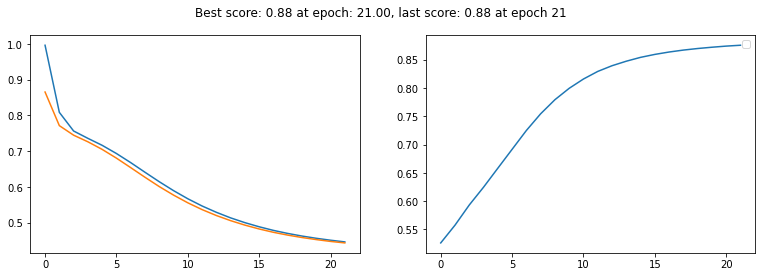

100%|██████████| 295/295 [00:10<00:00, 28.26it/s]


Test score: 0.88, test loss: 0.44


In [36]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = RippleNet(n_ent, n_rel, dim=8)
model.to(device)
opt = torch.optim.Adam(model.parameters(), 3e-4)

run(model, opt, test_loader, test_loader, test_loader, n_epoch=22)

with open("weights.pth", "wb") as f:
     torch.save(model.state_dict(), f)

Download your weights here and load to the model

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()
# model.load_state_dict(state_dict)

In [37]:
scores, embs = model(item.to(device), [[j.to(device) for j in i] for i in ripple])

labels = label.to(device)
bce, kge, l2 = compute_losses(scores, labels, *embs)
assert bce.item() < 0.6 and bce.item() > 0.3
assert kge.item() < 1 and kge.item() > 0.6

## Prediction example

Let us visualize some model predictions to understand how it works.

We will take the sample user with id 3084.

We want to predict scores for previously unseen items, so we select all unique items from ratings and remove the elements from user history.

In [38]:
user = 3084
items = torch.LongTensor(list(set(np.unique(ratings[:, 1])) - set(user_history_dict[user])))
ripples = train_dataset.ripple_set[user]

Now, we can calculate scores and take the top five items

In [39]:
scores, embs = model(items.to(device), [[i.reshape(1, -1).to(device) for i in ripple] for ripple in ripples])

top5 = items[scores.argsort()].numpy()[-5:]
top5

array([ 206,  780,  189, 2125,   31])

Let us check is there any intersection of our prediction and ground truth data

In [40]:
set(top5) & set(test_data[test_data[:, 0] == user][:, 1])

set()

Finally, we can visualize a subsample of the knowledge graph defined by user history and item 341

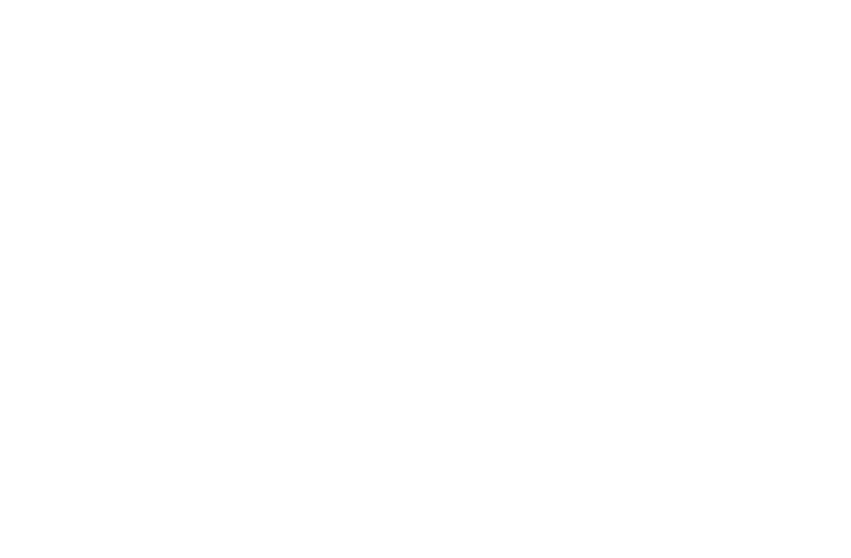

In [42]:
tmp = kg_edges_pd[kg_edges_pd["head"].isin(user_history_dict[user] + [1554])]
visualize_kg_part(1554, tmp[~(tmp.relation.str.contains("language")|tmp.relation.str.contains("country") |tmp.relation.str.contains("rating"))], 5)

We can see that given user watch many films of similar genres

Let us check another item that is wrong but appears within the top five predictions

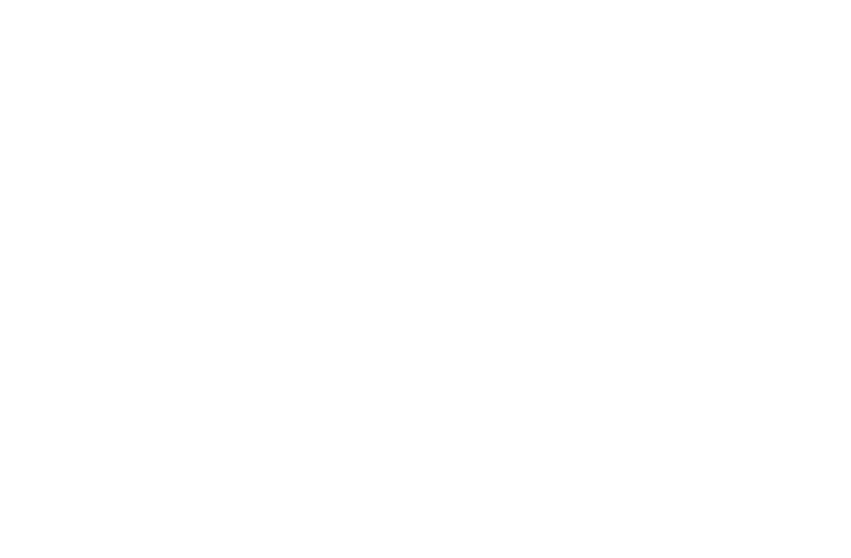

In [43]:
tmp = kg_edges_pd[kg_edges_pd["head"].isin(user_history_dict[user] + [740])]
visualize_kg_part(740, tmp[~(tmp.relation.str.contains("language")|tmp.relation.str.contains("country") |tmp.relation.str.contains("rating"))], 5)

Results for this prediction is similar. The user watches several films from the creators of Raiders of the Lost Ark and many films of similar genres. Moreover, this film is a part of an Indiana Jones series. The given user watched Indiana Jones and the Last Crusade previously